In [180]:
import os
import sys
import time
import json
import datetime
import random
import tarfile

import numpy as np
import pandas as pd
from PIL import Image

PATH = "../tubs/tub5"

In [181]:
#make sure tensorflow version is the same as one installed on donkeycar (1.8.0)
import tensorflow as tf
print(tf.__version__)

1.8.0


In [182]:
#check if GPU is present (/device:GPU:0)
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

['/device:GPU:0']

In [183]:
def json_to_df(PATH, json_files, max_items=None):
    df = pd.DataFrame()
    for i, j in enumerate(json_files[1:max_items]):
        with open(f'{PATH}/{j}') as f:
            data = json.load(f)

            userThrottle = data["user/throttle"]
            userAngle = data["user/angle"]
            camImage_array = data["cam/image_array"]
            index = int(camImage_array[:-21])
            df_row = pd.DataFrame([[userThrottle, userAngle, camImage_array]], index = [index], columns = ["user/throttle", "user/angle", "cam/image_array"])

            df = df.append(df_row)
    df = df.sort_index()
    return df

In [184]:
#df = json_to_df(PATH, json_files, max_items=None)

In [185]:
#df.to_feather('tmp/df')

In [186]:
df = pd.read_feather('tmp/df_wPATH')

C:\Users\Jason\Anaconda3\envs\tf-gpu\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [187]:
df.shape

(38574, 3)

In [188]:
df.head()

,user/throttle,user/angle,cam/image_array
0,0.08,0.01,../tubs/tub5/0_cam-image_array_.jpg
1,0.12,-0.03,../tubs/tub5/1_cam-image_array_.jpg
2,0.12,-0.03,../tubs/tub5/2_cam-image_array_.jpg
3,0.14,-0.06,../tubs/tub5/3_cam-image_array_.jpg
4,0.14,-0.06,../tubs/tub5/4_cam-image_array_.jpg


In [189]:
bs = 128 # or 128/3
train_frac = 0.8
X_keys = ['cam/image_array']
y_keys = ['user/angle', 'user/throttle']

In [190]:
def get_prev_img_names(img_name, quantity, skipFrame = 5):
    img_names = []
    last_name = img_name
    for i in range(0, quantity):
        path = img_name.split("/")
        index = int(path[-1][:-21])-skipFrame*i
        if index < 0:
            name = last_name
        else:
            path[-1] = str(index) + "_cam-image_array_.jpg"
            name = "/".join(path)
        
        img_names.append(name)
        last_name = name
    img_names.reverse()
    return img_names

In [191]:
images = get_prev_img_names("../tubs/tub5/543_cam-image_array_.jpg", 3)

In [192]:
images

['../tubs/tub5/533_cam-image_array_.jpg',
 '../tubs/tub5/538_cam-image_array_.jpg',
 '../tubs/tub5/543_cam-image_array_.jpg']

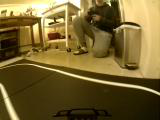

In [193]:
Image.open(images[0])

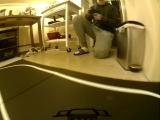

In [194]:
Image.open(images[1])

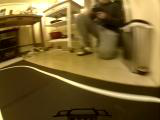

In [195]:
Image.open(images[2])

In [ ]:
def get_prev_angles(df, index, quantity):
    angles = []
    for i in range(quantity):
        angles.append(df['user/angle'][index-i])
    angles.reverse()
    return np.array(angles)

In [196]:
def to_bin(a):
    arr = np.zeros(15)
    a = a + 1
    b = round(a/(2/14))
    arr[int(b)] = 1
    return arr

In [197]:
def read_record(record_dict, path = PATH):
    data = {}
    for key, val in record_dict.items():
        if key == 'cam/image_array':
            images = get_prev_img_names(val, 3)
            data[key] = []
            for i, name in enumerate(images):
                img = Image.open(name)
                data[key].append(np.array(img))
            data[key] = np.array(data[key])
        else:
            data[key] = val
        
        
    return data

In [198]:
test = df.sample(n=1).to_dict(orient='record')[0]
record = read_record(test)
img_arrays = record['cam/image_array']

In [199]:
img_arrays.shape

(3, 120, 160, 3)

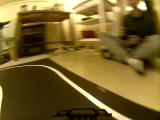

In [200]:
Image.fromarray(img_arrays[0])

In [201]:
def get_record_gen(record_transform=None, shuffle=True, df=None):
    while True:
        for _ in df.iterrows():
            if shuffle:
                record_dict = df.sample(n=1).to_dict(orient='record')[0]
            
            record_dict = read_record(record_dict)
            
            if record_transform:
                record_dict = record_transform(record_dict)
            
            yield record_dict

In [202]:
def get_batch_gen(keys=None, batch_size=128, record_transform=None, shuffle=True, df=None):
    
    record_gen = get_record_gen(record_transform=record_transform, shuffle=shuffle, df=df)
    
    while True:
        record_list = [next(record_gen) for _ in range(batch_size)]
        
        batch_arrays = {}
        for i, k in enumerate(keys):
            arr = np.array([r[k] for r in record_list])
            batch_arrays[k] = arr
        yield batch_arrays

In [203]:
def get_train_gen(X_keys, Y_keys, batch_size=128, record_transform=None, df=None): #
    batch_gen = get_batch_gen(X_keys + Y_keys, batch_size=batch_size,
                                  record_transform=record_transform, df=df)
    while True:
        batch = next(batch_gen)
        X = [batch[k] for k in X_keys]
        Y = [batch[k] for k in Y_keys] 
        yield X, Y

In [204]:
def get_train_val_gen(df, X_keys, Y_keys, batch_size = 128, train_frac=0.8, #
                      train_record_transform=None, val_record_transform=None): #
    train_df = df.sample(frac=train_frac, random_state=200) #
    val_df = df.drop(train_df.index) #
    
    train_gen = get_train_gen(X_keys=X_keys, Y_keys=Y_keys, batch_size=batch_size,
                             record_transform=train_record_transform, df=train_df)
    val_gen = get_train_gen(X_keys=X_keys, Y_keys=Y_keys, batch_size=batch_size,
                           record_transform=val_record_transform, df=val_df)
    return train_gen, val_gen
    

In [205]:
def record_transform(record):
    record['user/angle'] = to_bin(record['user/angle'])
    return record

In [206]:
train_gen, val_gen = get_train_val_gen(df, X_keys, y_keys,
                                               train_record_transform=record_transform, #
                                               val_record_transform=record_transform, #
                                               batch_size=bs, #
                                               train_frac=train_frac) #

In [207]:
#test = next(train_gen)

In [208]:
#test[0][0].shape

In [218]:
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.models import Model, load_model, Sequential
from tensorflow.python.keras.layers import MaxPooling3D, BatchNormalization, Convolution3D, Cropping3D 
from tensorflow.python.keras.layers import Dropout, Flatten, Dense, Cropping2D, Lambda
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

In [219]:
"""
#4 Kernels base reference architecture
new_model_path = 'models/pilot_3Dspeedup'

img_in3D = Input(shape=(3, 120, 160, 3), name='img_in')
x = img_in3D
x = Cropping3D(cropping = ((0, 0),(60, 0),(0, 0)))(x)

x = Convolution3D(4, (3, 5, 5), strides=(1, 4, 4), activation='relu')(x)
x = MaxPooling3D(pool_size=(1, 2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

x = Flatten(name='flattened')(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.2)(x)

angle_out = Dense(15, activation='softmax', name='angle_out')(x)
throttle_out = Dense(1, activation='relu', name='throttle_out')(x)


model = Model(inputs=[img_in3D], outputs=[angle_out, throttle_out])
model.compile(optimizer='adam', 
              loss={'angle_out': 'categorical_crossentropy',
                   'throttle_out': 'mean_absolute_error'},
              loss_weights={'angle_out': 0.9, 'throttle_out': 0.01})
"""

"\n#4 Kernels base reference architecture\nnew_model_path = 'models/pilot_3Dspeedup'\n\nimg_in3D = Input(shape=(3, 120, 160, 3), name='img_in')\nx = img_in3D\nx = Cropping3D(cropping = ((0, 0),(60, 0),(0, 0)))(x)\n\nx = Convolution3D(4, (3, 5, 5), strides=(1, 4, 4), activation='relu')(x)\nx = MaxPooling3D(pool_size=(1, 2, 2))(x)\nx = BatchNormalization()(x)\nx = Dropout(0.1)(x)\n\nx = Flatten(name='flattened')(x)\nx = Dense(50, activation='relu')(x)\nx = Dropout(0.2)(x)\n\nangle_out = Dense(15, activation='softmax', name='angle_out')(x)\nthrottle_out = Dense(1, activation='relu', name='throttle_out')(x)\n\n\nmodel = Model(inputs=[img_in3D], outputs=[angle_out, throttle_out])\nmodel.compile(optimizer='adam', \n              loss={'angle_out': 'categorical_crossentropy',\n                   'throttle_out': 'mean_absolute_error'},\n              loss_weights={'angle_out': 0.9, 'throttle_out': 0.01})\n"

In [220]:
new_model_path = 'models/pilot_3Dspeedup_skipFramex5_8Kernels_f355_s122'

img_in3D = Input(shape=(3, 120, 160, 3), name='img_in')
x = img_in3D
x = Cropping3D(cropping = ((0, 0),(60, 0),(0, 0)))(x)
#Try applying batchnorm here

x = Convolution3D(8, (3, 3, 3), strides=(1, 2, 2), activation='relu')(x)
x = MaxPooling3D(pool_size=(1, 2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

x = Flatten(name='flattened')(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.2)(x)

angle_out = Dense(15, activation='softmax', name='angle_out')(x)
throttle_out = Dense(1, activation='relu', name='throttle_out')(x)


model = Model(inputs=[img_in3D], outputs=[angle_out, throttle_out])
model.compile(optimizer='adam', 
              loss={'angle_out': 'categorical_crossentropy',
                   'throttle_out': 'mean_absolute_error'},
              loss_weights={'angle_out': 0.9, 'throttle_out': 0.01})

In [221]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 3, 120, 160,  0                                            
__________________________________________________________________________________________________
cropping3d_9 (Cropping3D)       (None, 3, 60, 160, 3 0           img_in[0][0]                     
__________________________________________________________________________________________________
conv3d_9 (Conv3D)               (None, 1, 29, 79, 8) 656         cropping3d_9[0][0]               
__________________________________________________________________________________________________
max_pooling3d_9 (MaxPooling3D)  (None, 1, 14, 39, 8) 0           conv3d_9[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [222]:
def train(train_gen, val_gen, saved_model_path, epochs=100, steps=100, train_split=0.8,
         verbose=1, min_delta=0.0005, patience=5, use_early_stop=True):
    
#     checkpoint to save model
    save_best = ModelCheckpoint(saved_model_path, monitor='val_loss', verbose=verbose, save_best_only=True, mode='min')
    
    #stop training if stop improving
    early_stop = EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience, verbose=verbose, mode='auto')
    
    callbacks_list = [save_best]
    
    if use_early_stop:
        callbacks_list.append(early_stop)
        
    hist = model.fit_generator(train_gen, steps_per_epoch=steps, epochs=epochs, verbose=1, validation_data=val_gen,
                                callbacks=callbacks_list, validation_steps=steps * (1.0 - train_frac)//train_frac)
    return hist

In [223]:
total_records = len(df)
total_train = int(total_records * train_frac)
total_val = total_records - total_train
steps_per_epoch = total_train // bs
steps_per_epoch

241

In [224]:
train(train_gen, val_gen, saved_model_path=new_model_path, steps=steps_per_epoch, train_split=0.8)

Epoch 1/100
240/241 [============================>.] - ETA: 0s - loss: 1.4949 - angle_out_loss: 1.6571 - throttle_out_loss: 0.3507
Epoch 00001: val_loss improved from inf to 1.21178, saving model to models/pilot_3Dspeedup_skipFramex5_8Kernels_f355_s122
241/241 [==============================] - 142s 588ms/step - loss: 1.4938 - angle_out_loss: 1.6559 - throttle_out_loss: 0.3506 - val_loss: 1.2118 - val_angle_out_loss: 1.3429 - val_throttle_out_loss: 0.3165
Epoch 2/100
240/241 [============================>.] - ETA: 0s - loss: 1.1243 - angle_out_loss: 1.2457 - throttle_out_loss: 0.3216
Epoch 00002: val_loss improved from 1.21178 to 1.08940, saving model to models/pilot_3Dspeedup_skipFramex5_8Kernels_f355_s122
241/241 [==============================] - 135s 558ms/step - loss: 1.1238 - angle_out_loss: 1.2451 - throttle_out_loss: 0.3216 - val_loss: 1.0894 - val_angle_out_loss: 1.2069 - val_throttle_out_loss: 0.3181
Epoch 3/100
240/241 [============================>.] - ETA: 0s - loss: 0.965

240/241 [============================>.] - ETA: 0s - loss: 0.4291 - angle_out_loss: 0.4764 - throttle_out_loss: 0.0394
Epoch 00020: val_loss improved from 0.67316 to 0.66311, saving model to models/pilot_3Dspeedup_skipFramex5_8Kernels_f355_s122
241/241 [==============================] - 132s 548ms/step - loss: 0.4293 - angle_out_loss: 0.4766 - throttle_out_loss: 0.0394 - val_loss: 0.6631 - val_angle_out_loss: 0.7364 - val_throttle_out_loss: 0.0391
Epoch 21/100
240/241 [============================>.] - ETA: 0s - loss: 0.4282 - angle_out_loss: 0.4754 - throttle_out_loss: 0.0376
Epoch 00021: val_loss did not improve
241/241 [==============================] - 130s 541ms/step - loss: 0.4279 - angle_out_loss: 0.4750 - throttle_out_loss: 0.0376 - val_loss: 0.6774 - val_angle_out_loss: 0.7523 - val_throttle_out_loss: 0.0386
Epoch 22/100
240/241 [============================>.] - ETA: 0s - loss: 0.4245 - angle_out_loss: 0.4713 - throttle_out_loss: 0.0380
Epoch 00022: val_loss did not improve
2

In [ ]:
"""
Records

GRU with rmsprop optimizer
record
241/241 [==============================] - 137s 570ms/step - loss: 1.6156 - angle_out_loss: 1.7943 
- throttle_out_loss: 0.0702 - val_loss: 2.1860 - val_angle_out_loss: 2.4283 - val_throttle_out_loss: 0.0526
Epoch 00010: early stopping

Basic Refference model: pilot_TdBasic
Original CNN -> TimeDistributed -> Flatten -> 1 Dense
241/241 [==============================] - 153s 636ms/step - loss: 0.6759 - angle_out_loss: 0.7502 - 
throttle_out_loss: 0.0649 - val_loss: 0.8818 - val_angle_out_loss: 0.9788 - val_throttle_out_loss: 0.0893
Epoch 00019: early stopping

Basic conv3D model: pilot_conv3D with rmsprop and no activation 
Original CNN -> TimeDistributed -> conv3D -> Flatten -> 1 Dense
241/241 [==============================] - 154s 641ms/step - loss: 0.6136 - angle_out_loss: 0.6812 -
throttle_out_loss: 0.0546 - val_loss: 0.7844 - val_angle_out_loss: 0.8709 - val_throttle_out_loss: 0.0511

All conv3D model: pilot_Allconv3D with adam
Con3D strides=(1, 2, 2): 24, (1, 5, 5) -> 32, (1, 5, 5) -> 64, (1, 5, 5) -> 64, (1, 3, 3) -> strides=(1, 1, 1): 64, (3, 3, 3) -> 
batchnorm -> flatten -> dense
At least
241/241 [==============================] - 140s 582ms/step - loss: 0.3661 - 
angle_out_loss: 0.4063 - throttle_out_loss: 0.0394 - val_loss: 0.6101 -
val_angle_out_loss: 0.6775 - val_throttle_out_loss: 0.0350
"""

In [68]:
model.evaluate_generator(train_gen, steps=10)

[0.4666158199310303, 0.5176802217960358, 0.07036299034953117]

In [58]:
#check against original
def unbin(arr):
    index = np.argmax(arr)
    return index/14*2-1
#     return index

In [59]:
unbin([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

0.0

In [60]:
def run(img_arr):
    img_arr = img_arr.reshape((1,) + img_arr.shape)
    angle_binned, throttle = model.predict(img_arr)
    angle_unbinned = unbin(angle_binned[0])
    return angle_unbinned, throttle[0][0]

In [61]:
frame_idx = 200 #500 - 600

In [65]:
img_name = df['cam/image_array'][frame_idx]
images = get_prev_img_names(img_name, 3)
val = []
for i, name in enumerate(images):
    img = Image.open(f'{PATH}/{img_name}')
    val.append(np.array(img))
val = np.array(val)

In [66]:
val.shape

(3, 120, 160, 3)

In [67]:
#prediction
run(val)

(-0.4285714285714286, 0.30532354)

In [125]:
#compare to actual data
df['user/angle'][frame_idx], df['user/throttle'][frame_idx]

(-0.45, 0.29)

In [126]:
df['user/angle'][frame_idx-1], df['user/throttle'][frame_idx-1]

(-0.53, 0.33)

In [127]:
df['user/angle'][frame_idx-2], df['user/throttle'][frame_idx-2]

(-0.53, 0.33)

In [ ]:
"""
4 Kernels base reference architecture
new_model_path = 'models/pilot_3Dspeedup'

img_in3D = Input(shape=(3, 120, 160, 3), name='img_in')
x = img_in3D
x = Cropping3D(cropping = ((0, 0),(60, 0),(0, 0)))(x)

x = Convolution3D(4, (3, 5, 5), strides=(1, 4, 4), activation='relu')(x)
x = MaxPooling3D(pool_size=(1, 2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

x = Flatten(name='flattened')(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.2)(x)

angle_out = Dense(15, activation='softmax', name='angle_out')(x)
throttle_out = Dense(1, activation='relu', name='throttle_out')(x)


model = Model(inputs=[img_in3D], outputs=[angle_out, throttle_out])
model.compile(optimizer='adam', 
              loss={'angle_out': 'categorical_crossentropy',
                   'throttle_out': 'mean_absolute_error'}, #should I use a different loss function because of gru?
              loss_weights={'angle_out': 0.9, 'throttle_out': 0.01}) # should throttle weight be adjusted?
"""